In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [2]:
df_raw = pd.read_csv('data-task-co2r.csv')

df_raw.loc[(df_raw["answer"] == 'body(animal)'), 'answer'] = 'body (animal)' # fix typo

df = (df_raw
        .loc[:, ['Trial Number', 'Screen Name', 'Reaction Time', 'Response', 'display', 'image', 'answer']]
        .drop(df_raw[df_raw["Zone Name"] == "timer"].index) # drop timer info
        .drop(df_raw[~df_raw["Screen Name"].isin(["Mooney", "grayscale"])].index) # keep trial screens only
        .assign(correct=lambda x: x.apply(lambda y: 1 if y['answer'] == y['Response'] else 0, axis=1))
        .assign(keyword=lambda x: x["image"]
                                        .apply(lambda s: s.split("_")[1] 
                                                            if (s.split("_")[0] == "dis")
                                                            else s.split("_")[0]))
    )

# df.head()
df.describe()

,Reaction Time,correct
count,354.000000,354.000000
mean,1760.850282,0.709040
std,418.051541,0.454848
min,886.000000,0.000000
25%,1421.250000,0.000000
50%,1726.000000,1.000000
75%,2059.750000,1.000000
max,2916.000000,1.000000


In [3]:
# global vars, plotting functions

CATEGORIES = sorted(df["answer"].unique())

def plot_categories(df, title, cats=CATEGORIES, group=False):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25,8))
    sns.barplot(x='answer', y='correct', data=df, errorbar=None, ax=ax1, order=cats, hue='display' if group else None)
    sns.boxplot(x='answer', y='Reaction Time', data=df, ax=ax2, order=cats, hue='display' if group else None)
    fig.suptitle(title)


def plot_keywords(df, title, group=False):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(25,25))
    sns.barplot(x='keyword', y='correct', data=df, errorbar=None, ax=ax1, hue='display' if group else None)
    sns.boxplot(x='keyword', y='Reaction Time', data=df, ax=ax2, hue='display' if group else None)
    fig.suptitle(title)

In [4]:
# check if all images were shown, drop if not

checkdf = df.copy(deep=True)

f = lambda s: s[4:] if s[:4] == "dis_" else s

checkdf["image"] = checkdf["image"].apply(f)

counts = checkdf["image"].value_counts()
imgs_to_drop = list(counts[counts < 3].keys()) + list(map(lambda s: "dis_" + s, counts[counts < 3].keys()))

df = df[~df["image"].isin(imgs_to_drop)]

assert len(checkdf) == len(df) + sum(counts[counts < 3])
print(f"imgs without a match ({len(imgs_to_drop)}): \n", imgs_to_drop)

imgs without a match (24): 
 ['gymnast_132.jpg', 'boat_32.jpg', 'elephant_18.jpg', 'boat_13.jpg', 'houseplant_125.jpg', 'boat_37.jpg', 'man_s face_138.jpg', 'pineapple_47.jpg', 'tennis_player_40.jpg', 'boat_50.jpg', 'boat_56.jpg', 'boat_52.jpg', 'dis_gymnast_132.jpg', 'dis_boat_32.jpg', 'dis_elephant_18.jpg', 'dis_boat_13.jpg', 'dis_houseplant_125.jpg', 'dis_boat_37.jpg', 'dis_man_s face_138.jpg', 'dis_pineapple_47.jpg', 'dis_tennis_player_40.jpg', 'dis_boat_50.jpg', 'dis_boat_56.jpg', 'dis_boat_52.jpg']


In [5]:
pd.merge(
    df.loc[df["Reaction Time"] == max(df["Reaction Time"])],
    df.loc[df["Reaction Time"] == min(df["Reaction Time"])],
    how='outer'
)


,Trial Number,Screen Name,Reaction Time,Response,display,image,answer,correct,keyword
0,21,Mooney,2916.0,body (animal),pre,elephant_5.jpg,body (animal),1,elephant
1,64,Mooney,886.0,vehicle,post,train_129.jpg,vehicle,1,train


<AxesSubplot: xlabel='display', ylabel='Reaction Time'>

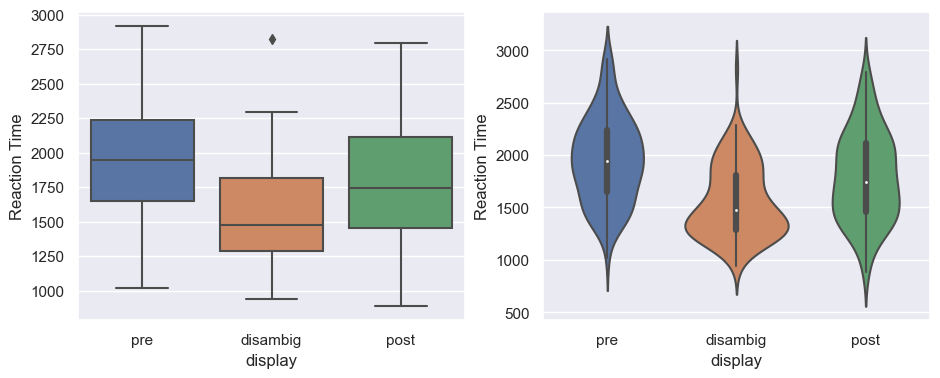

In [6]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11,4))

sns.boxplot(x='display', y='Reaction Time', data=df, ax=ax1)
sns.violinplot(x='display', y='Reaction Time', data=df, ax=ax2)

### categories

Text(0.5, 0.98, 'Correct per category - pre x post disambiguation')

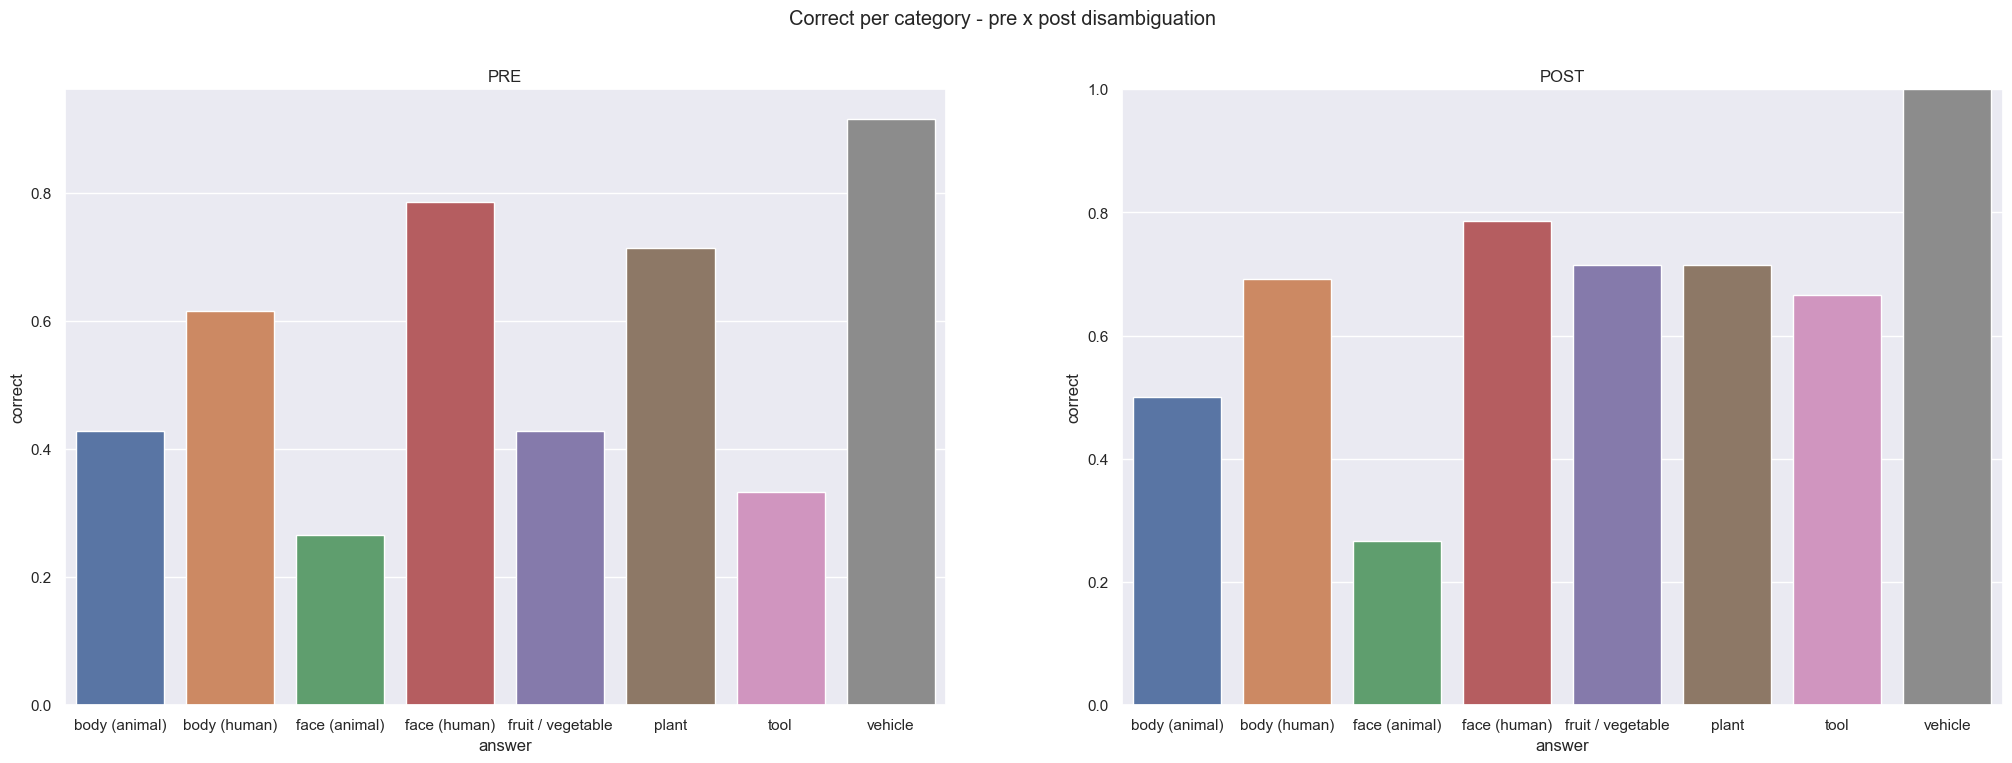

In [7]:
df_mooney_pre = df[(df["Screen Name"] == "Mooney") & (df["display"] == "pre")]
df_gray_disambig = df[(df["Screen Name"] == "grayscale") & (df["display"] == "disambig")]
df_mooney_post = df[(df["Screen Name"] == "Mooney") & (df["display"] == "post")]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25,8))
sns.barplot(x='answer', y='correct', data=df_mooney_pre, errorbar=None, ax=ax1, order=CATEGORIES).set(title="PRE")
sns.barplot(x='answer', y='correct', data=df_mooney_post, errorbar=None, ax=ax2, order=CATEGORIES).set(title="POST")
plt.ylim(0,1)
fig.suptitle("Correct per category - pre x post disambiguation")

In [8]:
df_mooney_pre

,Trial Number,Screen Name,Reaction Time,Response,display,image,answer,correct,keyword
4,1,Mooney,1787.0,plant,pre,broccoli_75.jpg,fruit / vegetable,0,broccoli
7,2,Mooney,1528.0,vehicle,pre,airplane_15.jpg,vehicle,1,airplane
10,3,Mooney,2339.0,plant,pre,cat_62.jpg,face (animal),0,cat
15,5,Mooney,2804.0,face (animal),pre,garden tools_194.jpg,tool,0,garden tools
18,6,Mooney,1565.0,body (animal),pre,cow_old_77.jpg,face (animal),0,cow
...,...,...,...,...,...,...,...,...,...
1014,116,Mooney,1969.0,body (animal),pre,fish_84.jpg,body (animal),1,fish
1017,117,Mooney,1951.0,face (human),pre,baby_s face_4.jpg,face (human),1,baby
1020,118,Mooney,2148.0,plant,pre,tennis_player_71.jpg,body (human),0,tennis
1023,119,Mooney,1843.0,face (human),pre,woman_s face_51.jpg,face (human),1,woman


In [9]:
print("PRE", df_mooney_pre.groupby("answer").mean(numeric_only=True), "\n\n", 
    "POST", df_mooney_post.groupby("answer").mean(numeric_only=True))

PRE                    Reaction Time   correct
answer                                    
body (animal)        2140.285714  0.428571
body (human)         1939.846154  0.615385
face (animal)        2064.400000  0.266667
face (human)         1839.785714  0.785714
fruit / vegetable    1866.000000  0.428571
plant                1964.642857  0.714286
tool                 2108.533333  0.333333
vehicle              1648.166667  0.916667 

 POST                    Reaction Time   correct
answer                                    
body (animal)        1994.928571  0.500000
body (human)         1875.461538  0.692308
face (animal)        1969.133333  0.266667
face (human)         1608.642857  0.785714
fruit / vegetable    1742.285714  0.714286
plant                1911.928571  0.714286
tool                 1715.066667  0.666667
vehicle              1483.000000  1.000000


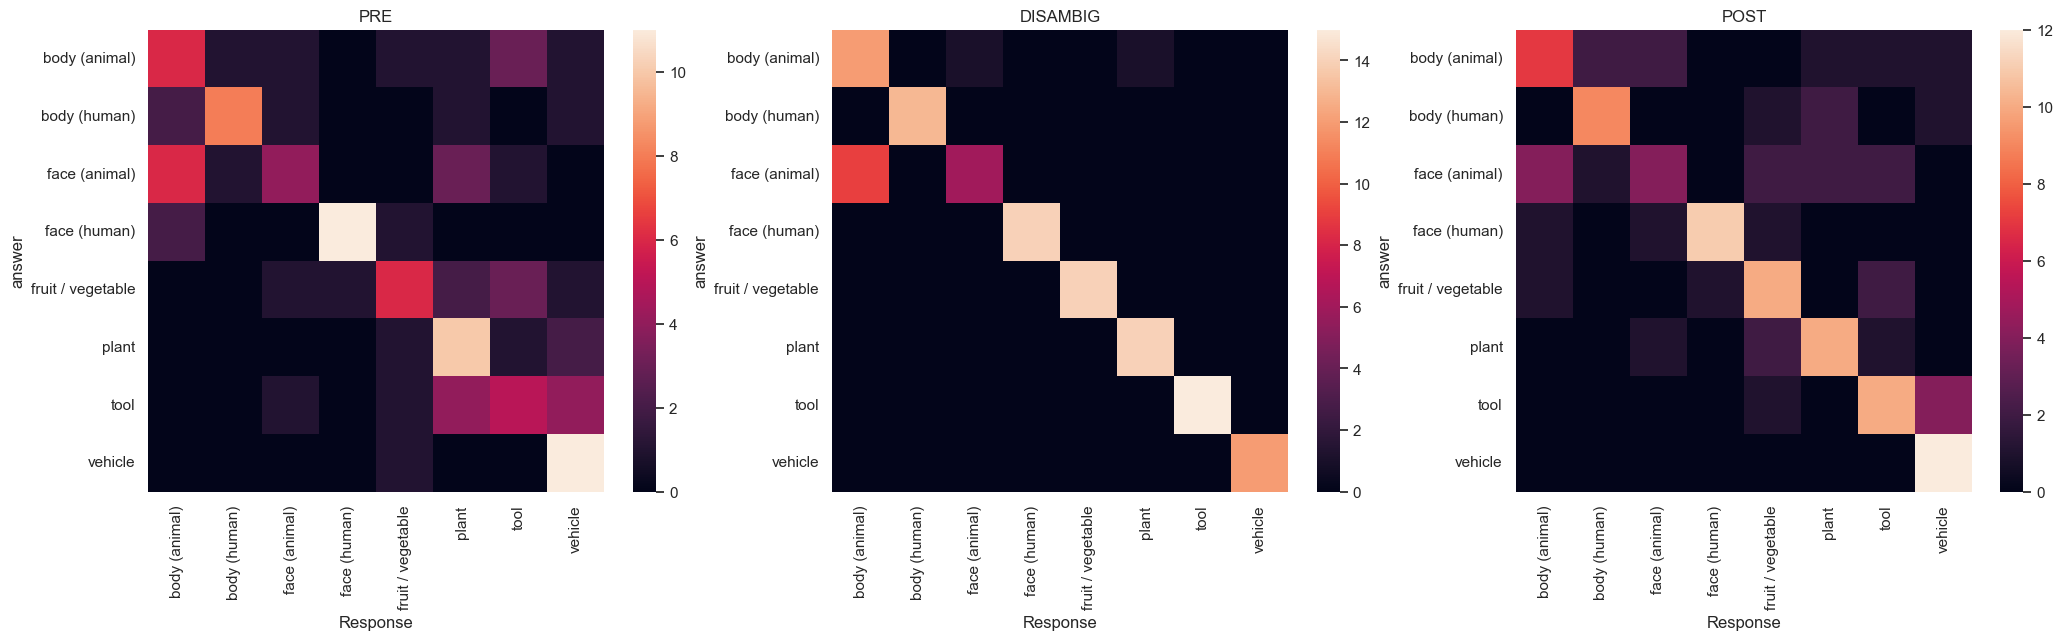

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,6))
for i, df in enumerate((df_mooney_pre, df_gray_disambig, df_mooney_post)):
    crosstab = pd.crosstab(df['answer'], df['Response'])
    sns.heatmap(crosstab, ax=ax[i]).set_title(("PRE", "DISAMBIG", "POST")[i])

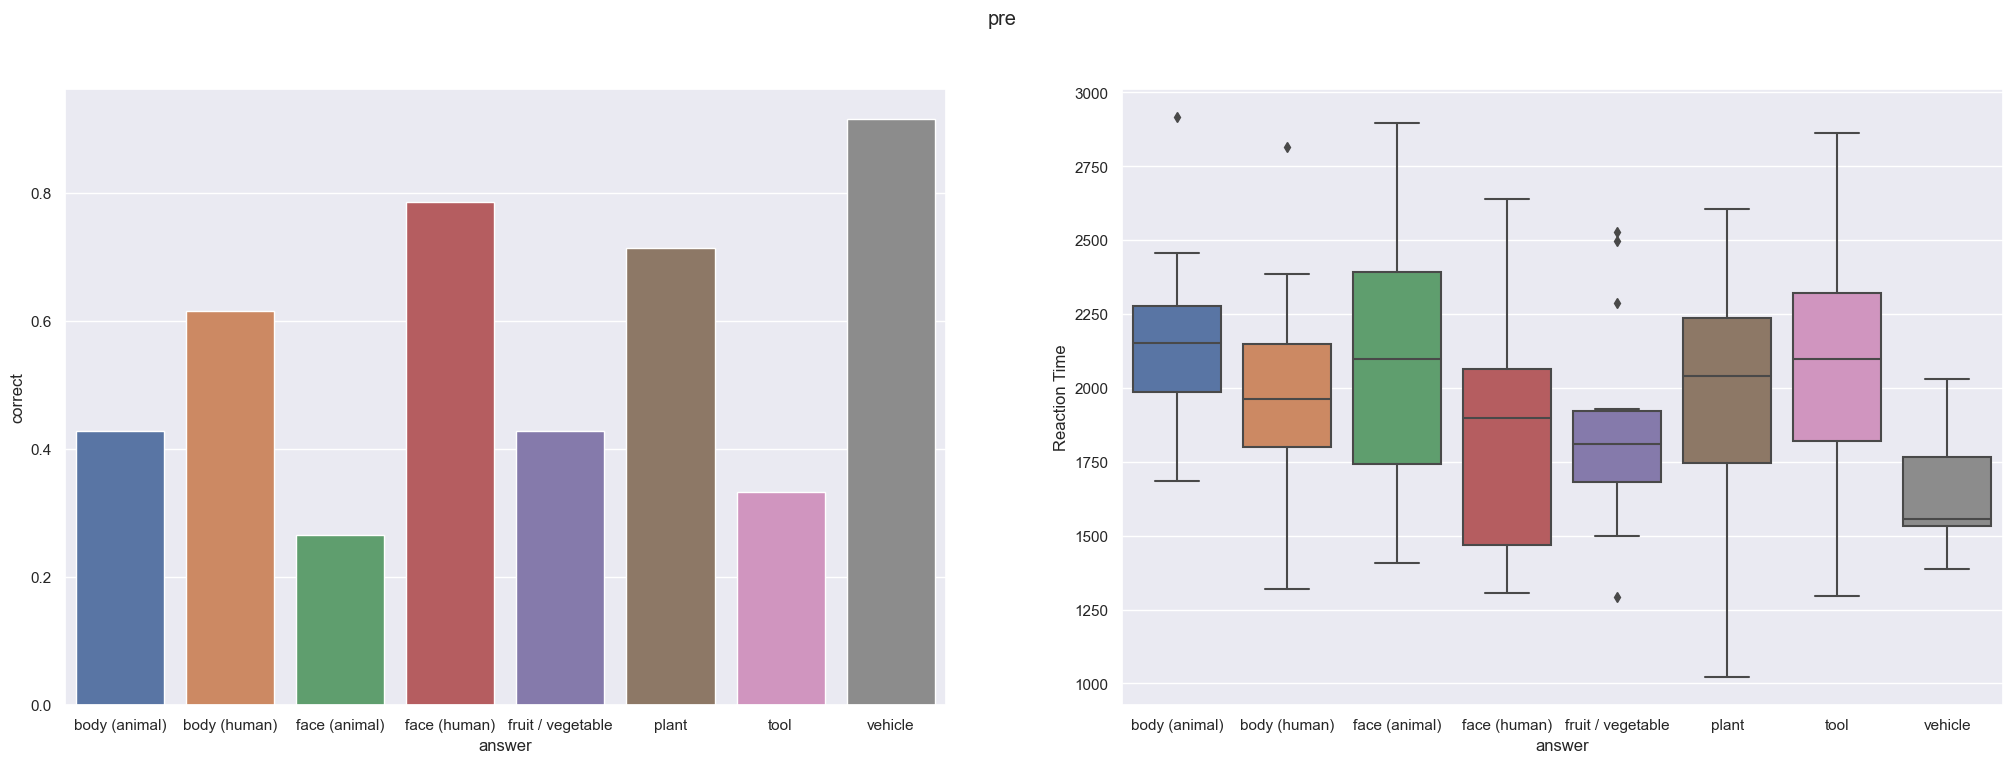

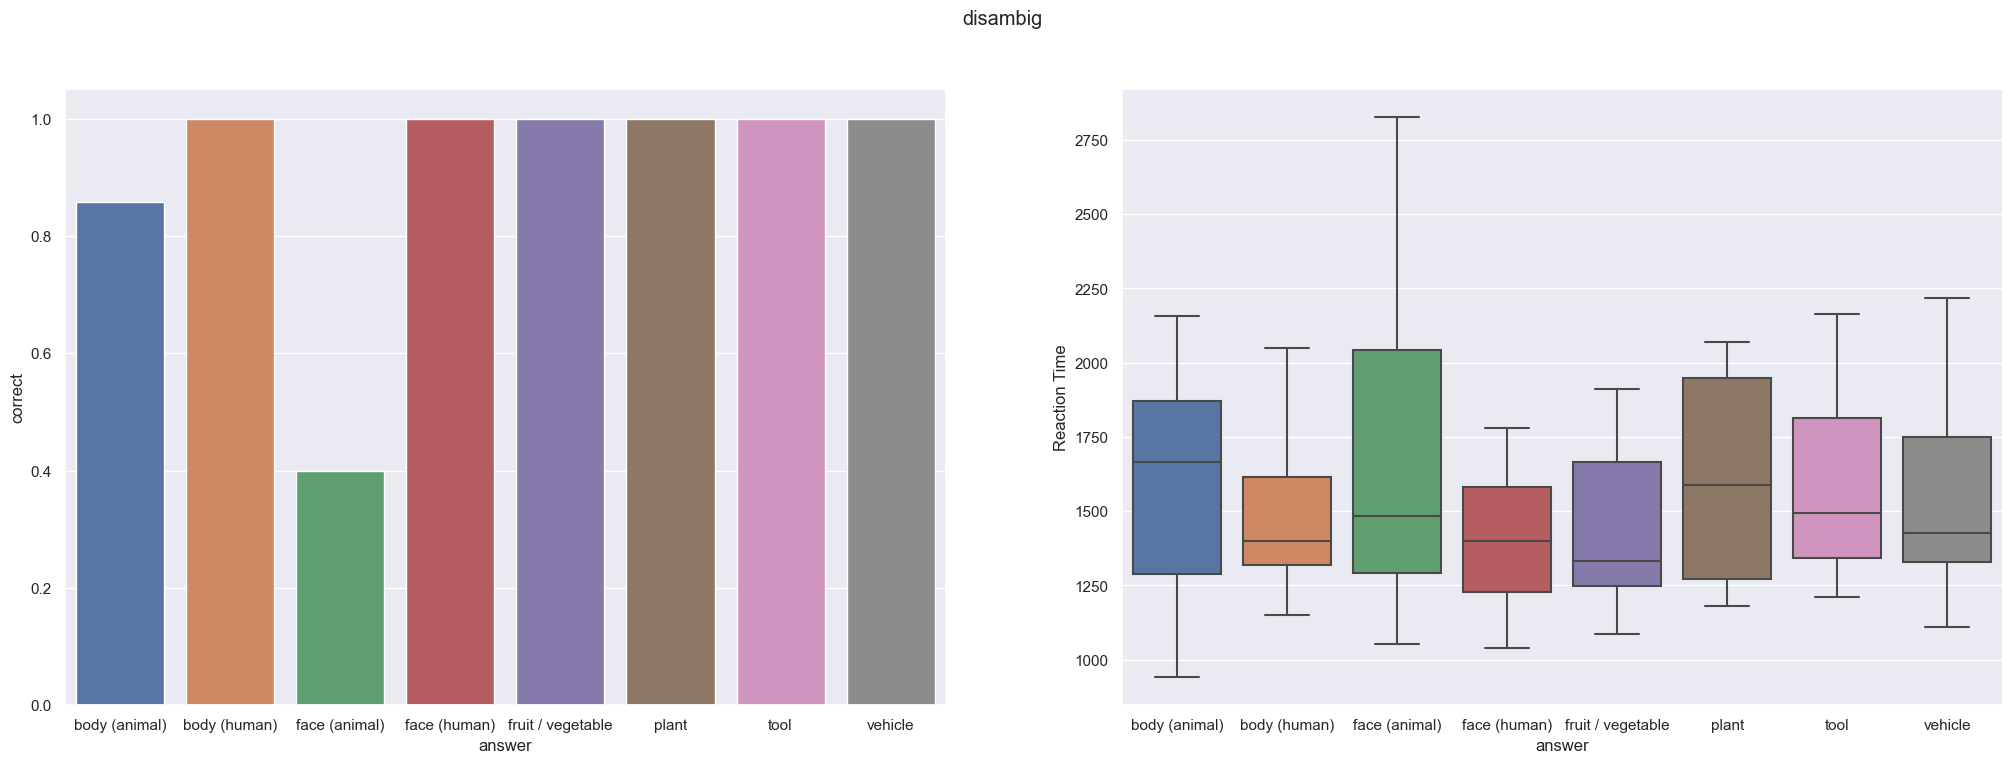

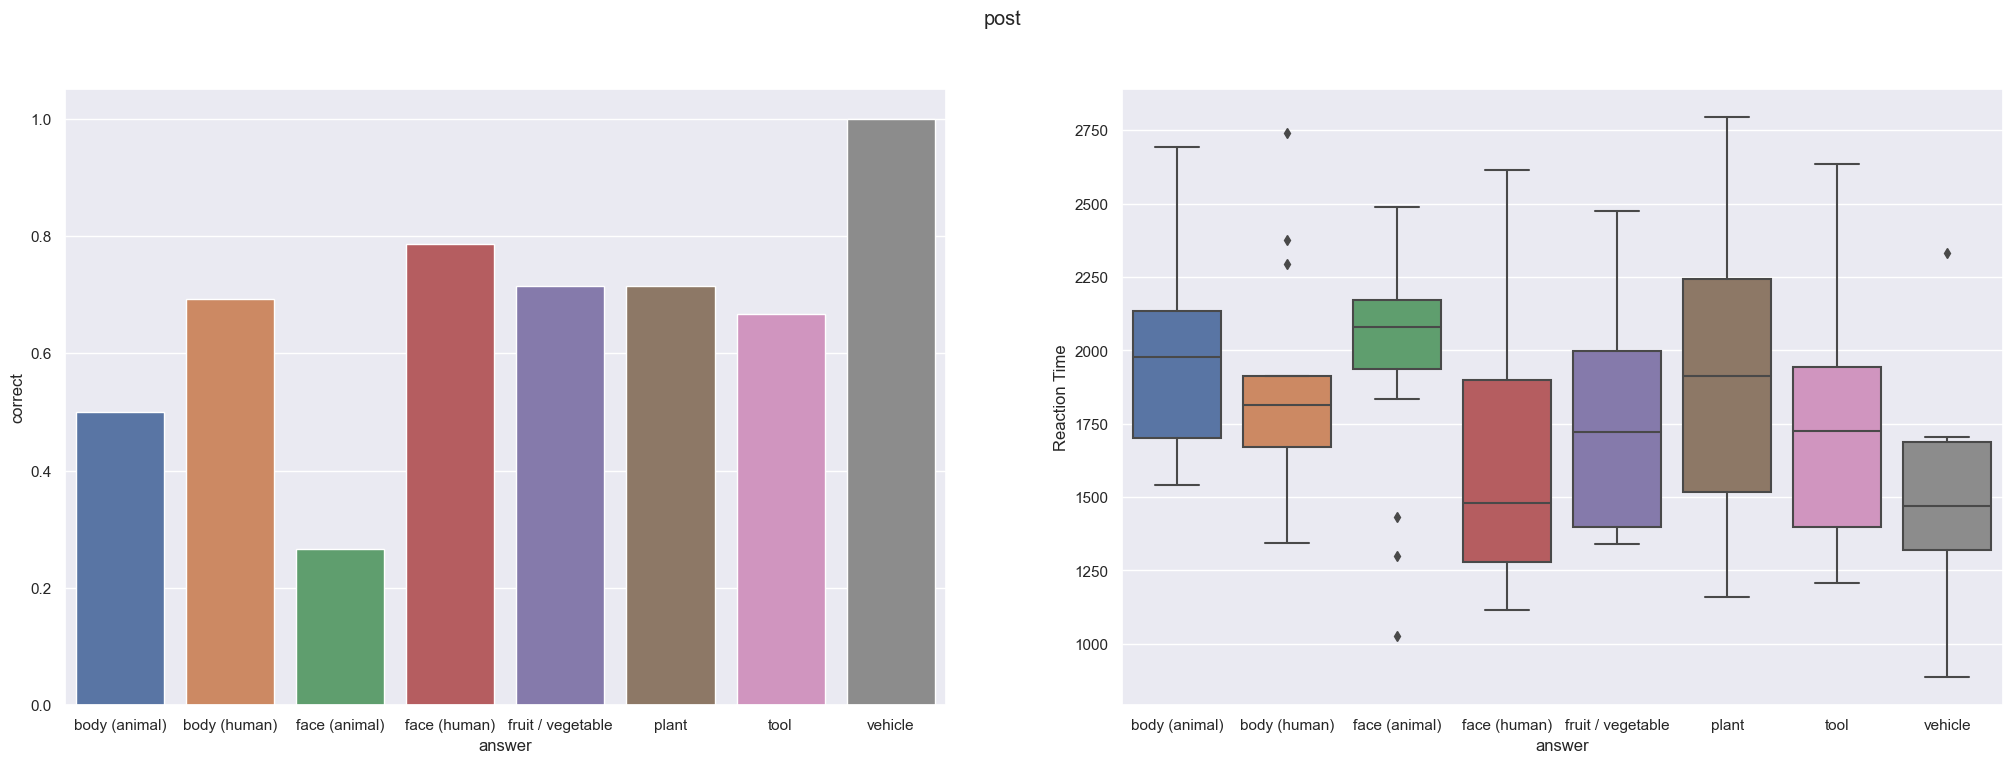

In [11]:
# corectness x RTs

plot_categories(df_mooney_pre, "pre")
plot_categories(df_gray_disambig, "disambig")
plot_categories(df_mooney_post, "post")

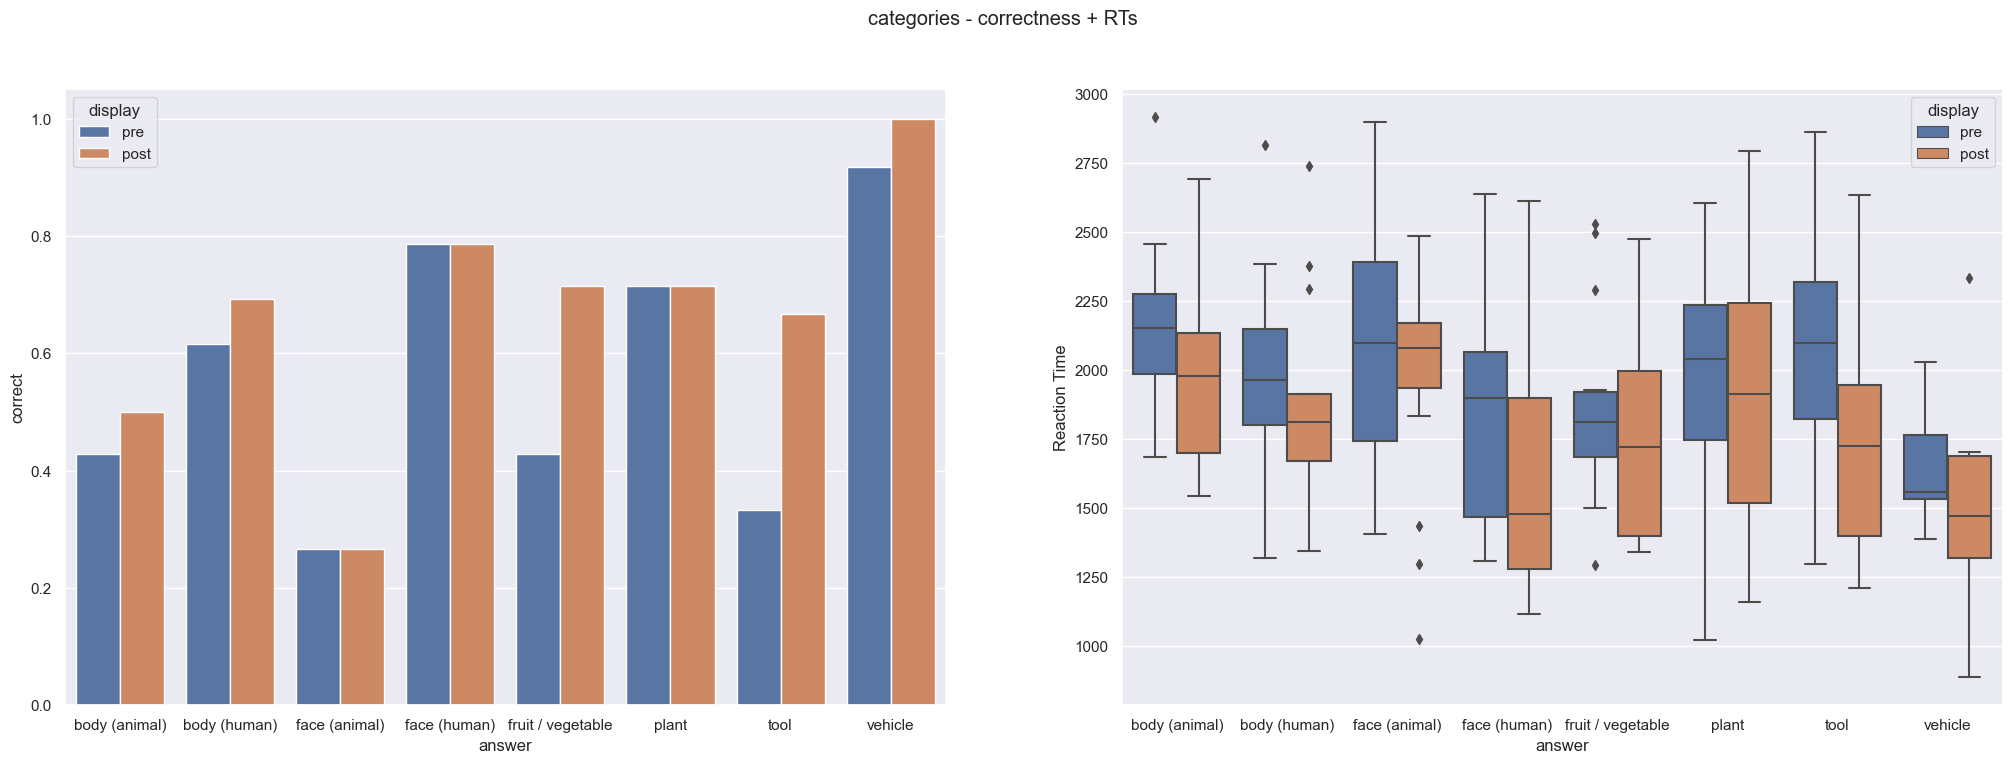

In [12]:
# % correct, RTs by category (paired)
plot_categories(pd.concat([df_mooney_pre, df_mooney_post]), 
                "categories - correctness + RTs", 
                group=True
                )

/var/folders/_d/qvcv_ff152x0rbzkxc1g5q2r0000gn/T/ipykernel_66728/911897543.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(['{:,.2%}'.format(x) for x in ax[0].get_yticks()]);


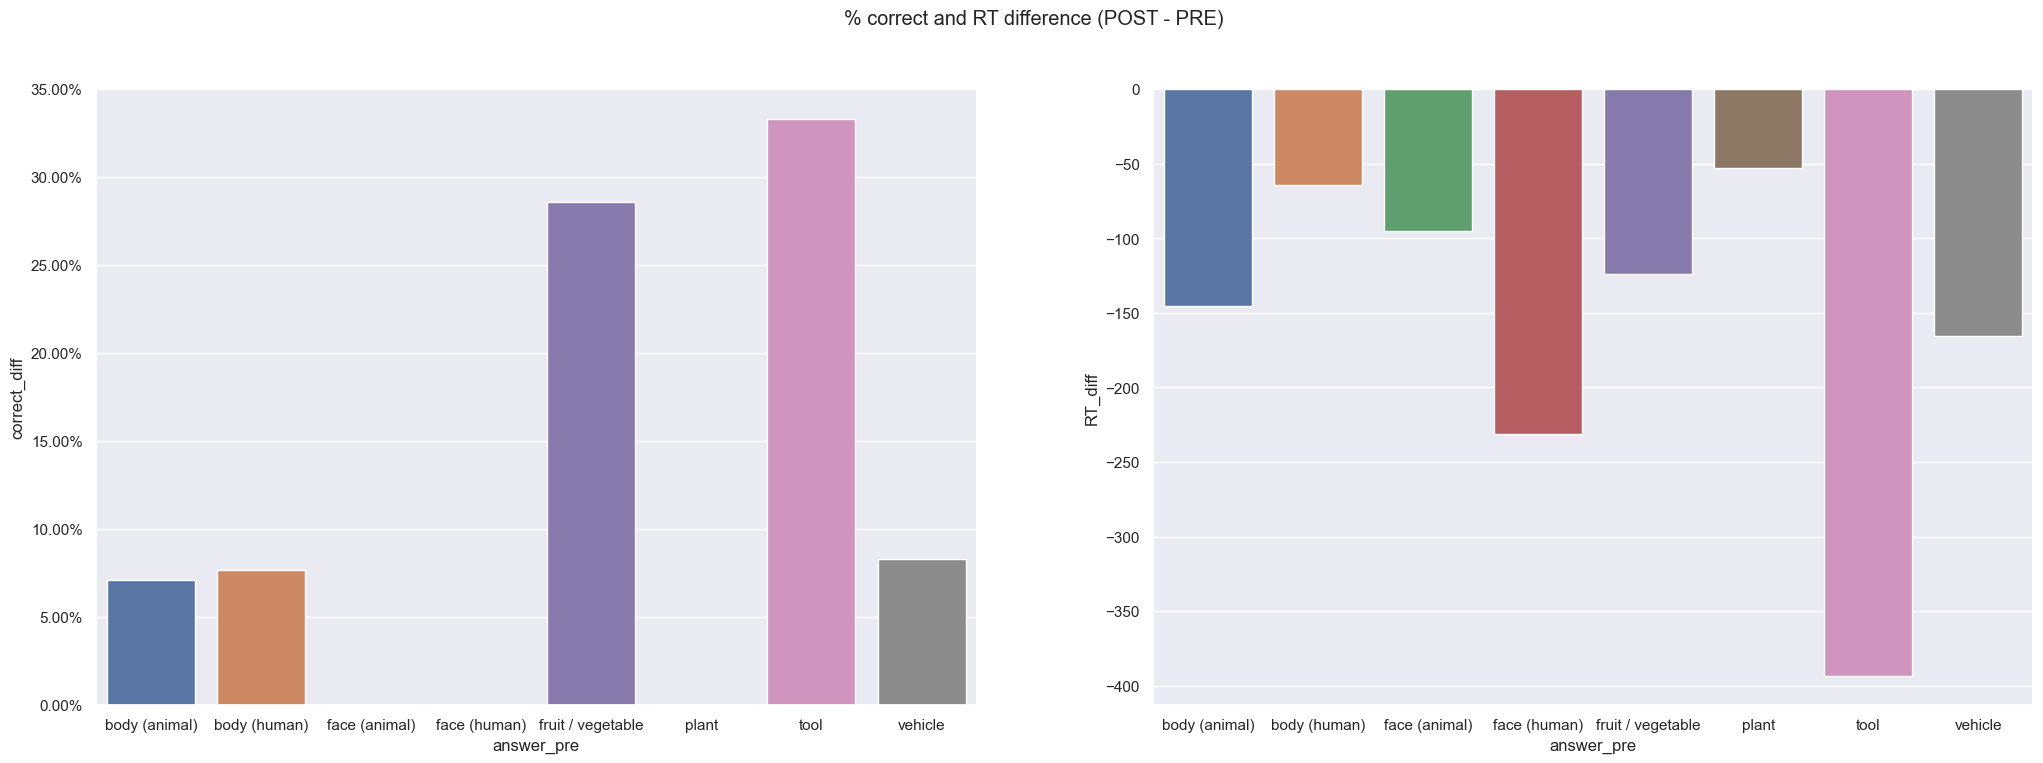

In [19]:
# paired difference - (pre - post) RT for each category, % correct
df_pre_post = pd.merge(left=df_mooney_pre, right=df_mooney_post, on='image', how='outer', suffixes=('_pre', '_post'))
df_pre_post = (df_pre_post
                .assign(RT_diff=lambda x: x['Reaction Time_post'] - x['Reaction Time_pre'])
                .assign(correct_diff=lambda x: x['correct_post'] - x['correct_pre'])
                .loc[:, ['image', 'answer_pre', 'RT_diff', 'correct_diff']]
            )

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,8))
fig.suptitle("% correct and RT difference (POST - PRE)")
sns.barplot(data=df_pre_post, x='answer_pre', y='RT_diff', order=CATEGORIES, errorbar=None, ax=ax[1])
sns.barplot(data=df_pre_post, x='answer_pre', y='correct_diff', order=CATEGORIES, errorbar=None, ax=ax[0])

ax[0].set_yticklabels(['{:,.2%}'.format(x) for x in ax[0].get_yticks()]);

### search terms (keywords) & images

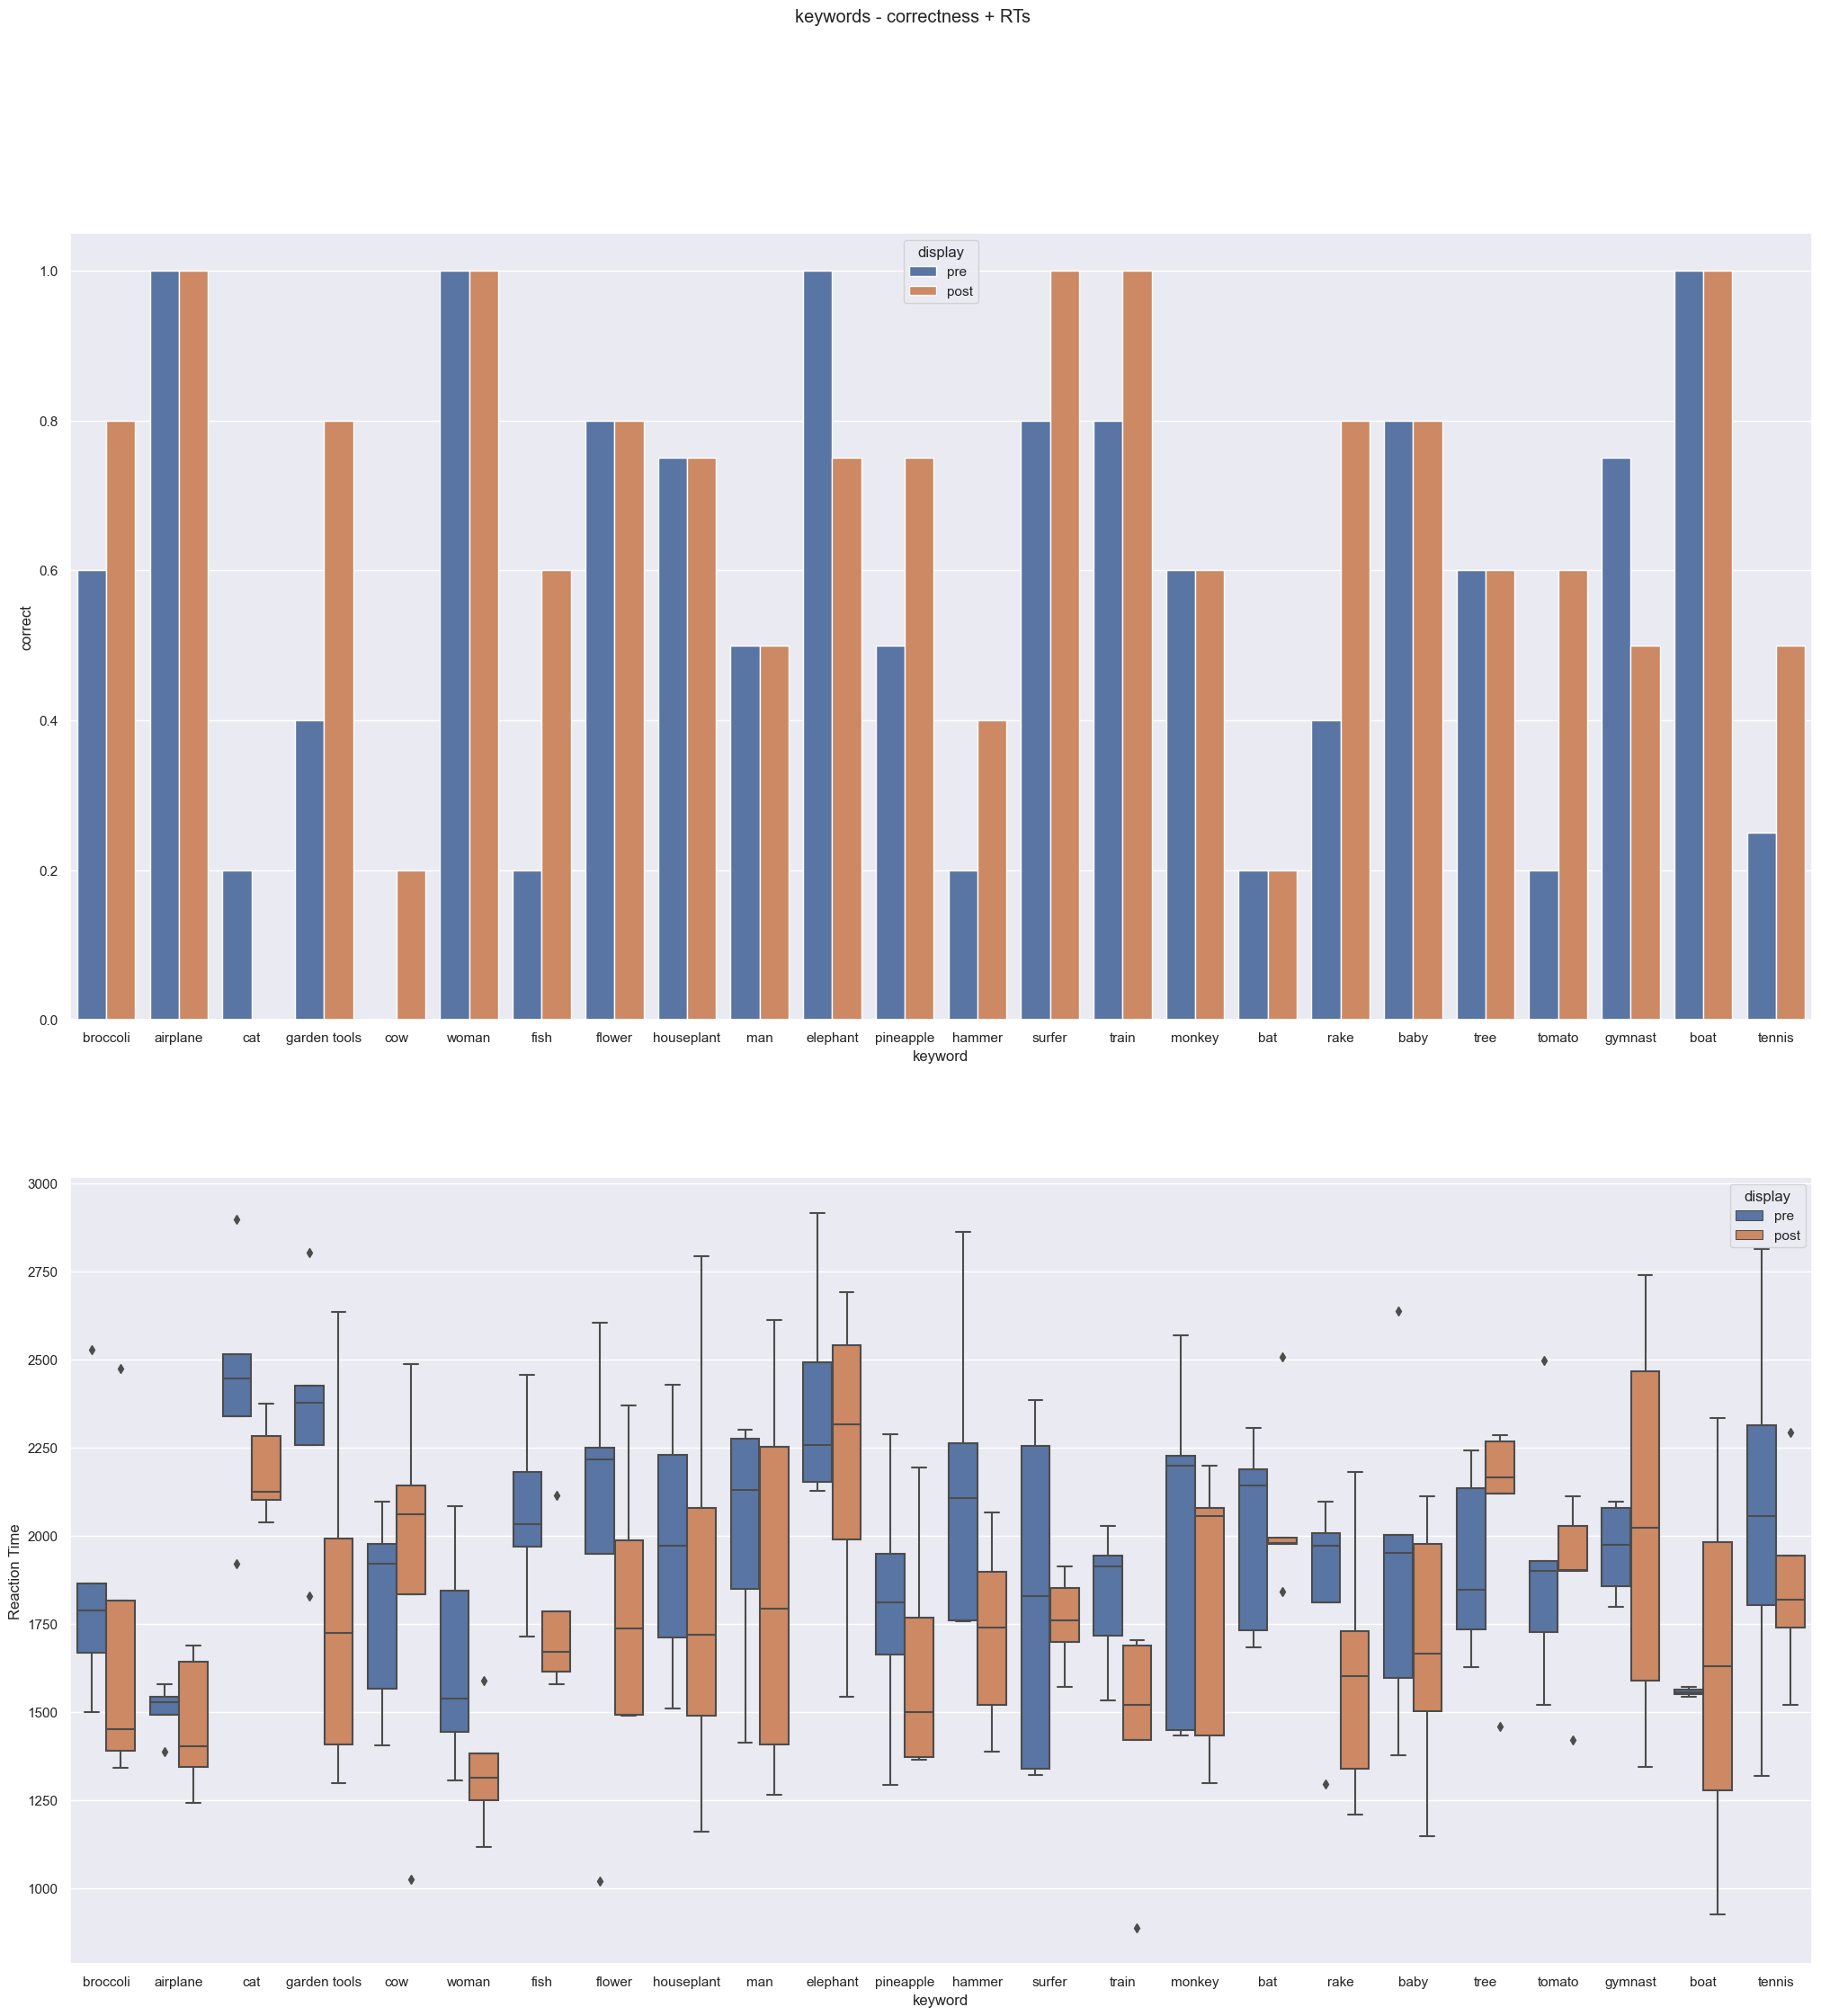

In [14]:
# PLOT for each search term (not subsearch)

plot_keywords(pd.concat([df_mooney_pre, df_mooney_post]), 
                "keywords - correctness + RTs", 
                group=True
                )

In [15]:
# incorrect gray -> confusing categorization

incorrect_gray = df_gray_disambig[df_gray_disambig["correct"] == 0]
incorrect_gray[["image", "Response", "answer", "keyword"]]

,image,Response,answer,keyword
53,dis_cat_62.jpg,body (animal),face (animal),cat
59,dis_cow_old_77.jpg,body (animal),face (animal),cow
150,dis_cat_61.jpg,body (animal),face (animal),cat
400,dis_cat_106.jpg,body (animal),face (animal),cat
488,dis_cow_old_63.jpg,body (animal),face (animal),cow
491,dis_fish_53.jpg,face (animal),body (animal),fish
691,dis_cow_old_9.jpg,body (animal),face (animal),cow
865,dis_monkey_147.jpg,body (animal),face (animal),monkey
950,dis_cow_old_20.jpg,body (animal),face (animal),cow
1038,dis_fish_84.jpg,plant,body (animal),fish


In [16]:
# incorrect post (- incorrect gray) -> Mooney too difficult?

incorrect_post = df_mooney_post[df_mooney_post["correct"] == 0]
print([im for im in incorrect_post["image"].values if "dis_" + im not in incorrect_gray["image"].values])

['man_s face_129.jpg', 'flower_12.jpg', 'cat_93.jpg', 'hammer_2_2.jpg', 'monkey_143.jpg', 'rake_136.jpg', 'man_s face_125.jpg', 'elephant_10.jpg', 'tomato_86.jpg', 'gymnast_128.jpg', 'hammer_2_6.jpg', 'bat_65.jpg', 'houseplant_129.jpg', 'tennis_player_76.jpg', 'pineapple_68.jpg', 'broccoli_92.jpg', 'garden tools_33.jpg', 'bat_49.jpg', 'hammer_2_1.jpg', 'monkey_136.jpg', 'baby_s face_22.jpg', 'bat_61.jpg', 'cat_97.jpg', 'tree_10.jpg', 'bat_41.jpg', 'tree_4.jpg', 'tennis_player_71.jpg', 'gymnast_133.jpg', 'tomato_94.jpg']


In [17]:
# correct pre -> Mooney too easy?
correct_pre = df_mooney_pre[df_mooney_pre["correct"] == 1]
correct_pre["image"].values

array(['airplane_15.jpg', 'woman_s face_119.jpg', 'broccoli_66.jpg',
       'flower_12.jpg', 'elephant_14.jpg', 'pineapple_44.jpg',
       'hammer_2_0.jpg', 'train_100.jpg', 'elephant_5.jpg',
       'surfer_121.jpg', 'cat_93.jpg', 'train_11.jpg',
       'garden tools_29.jpg', 'airplane_18.jpg', 'broccoli_80.jpg',
       'flower_48.jpg', 'pineapple_55.jpg', 'bat_51.jpg', 'rake_136.jpg',
       'baby_s face_27.jpg', 'tomato_91.jpg', 'houseplant_122.jpg',
       'broccoli_47.jpg', 'elephant_10.jpg', 'airplane_0.jpg',
       'flower_0.jpg', 'woman_s face_108.jpg', 'garden tools_122.jpg',
       'surfer_110.jpg', 'gymnast_122.jpg', 'airplane_1.jpg',
       'gymnast_128.jpg', 'rake_135.jpg', 'woman_s face_113.jpg',
       'tree_11.jpg', 'train_129.jpg', 'baby_s face_8.jpg',
       'monkey_97.jpg', 'houseplant_129.jpg', 'boat_96.jpg',
       'gymnast_34.jpg', 'woman_s face_53.jpg', 'airplane_60.jpg',
       'flower_54.jpg', 'man_s face_135.jpg', 'houseplant_113.jpg',
       'surfer_120.jpg', 